In [28]:
import numpy as np
import random
import pandas as pd 

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.pyplot as plt
import os

/tmp/ipykernel_6916/1731859760.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
files = os.listdir('../data-corrected')
files.sort()
print(files)

['ADANIPORTS.csv', 'ASIANPAINT.csv', 'AXISBANK.csv', 'BAJAJ-AUTO.csv', 'BAJAJFINSV.csv', 'BAJFINANCE.csv', 'BHARTIARTL.csv', 'BPCL.csv', 'BRITANNIA.csv', 'CIPLA.csv', 'COALINDIA.csv', 'DRREDDY.csv', 'EICHERMOT.csv', 'GAIL.csv', 'GRASIM.csv', 'HCLTECH.csv', 'HDFC.csv', 'HDFCBANK.csv', 'HEROMOTOCO.csv', 'HINDALCO.csv', 'HINDUNILVR.csv', 'ICICIBANK.csv', 'INDUSINDBK.csv', 'INFRATEL.csv', 'INFY.csv', 'IOC.csv', 'ITC.csv', 'JSWSTEEL.csv', 'KOTAKBANK.csv', 'LT.csv', 'MARUTI.csv', 'MM.csv', 'NESTLEIND.csv', 'NTPC.csv', 'ONGC.csv', 'POWERGRID.csv', 'RELIANCE.csv', 'SBIN.csv', 'SHREECEM.csv', 'SUNPHARMA.csv', 'TATAMOTORS.csv', 'TATASTEEL.csv', 'TCS.csv', 'TECHM.csv', 'TITAN.csv', 'ULTRACEMCO.csv', 'UPL.csv', 'VEDL.csv', 'WIPRO.csv', 'ZEEL.csv']


In [9]:
dpath = '../data-corrected/'
df = pd.read_csv(dpath + files[0]).set_index('Date')
df = df[['Close']]

In [12]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [36]:
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2610, 59, 1)
y_train.shape =  (2610, 1)
x_test.shape =  (652, 59, 1)
y_test.shape =  (652, 1)


In [37]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [39]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [40]:
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.0744742676615715
Epoch  20 MSE:  0.03779643401503563
Epoch  30 MSE:  0.005087601952254772
Epoch  40 MSE:  0.0019622540567070246
Epoch  50 MSE:  0.0009451131918467581
Epoch  60 MSE:  0.000759309739805758
Epoch  70 MSE:  0.0007501368527300656
Epoch  80 MSE:  0.0006571965059265494
Epoch  90 MSE:  0.0006246276316232979


In [41]:
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 47.70 RMSE
Test Score: 320.71 RMSE


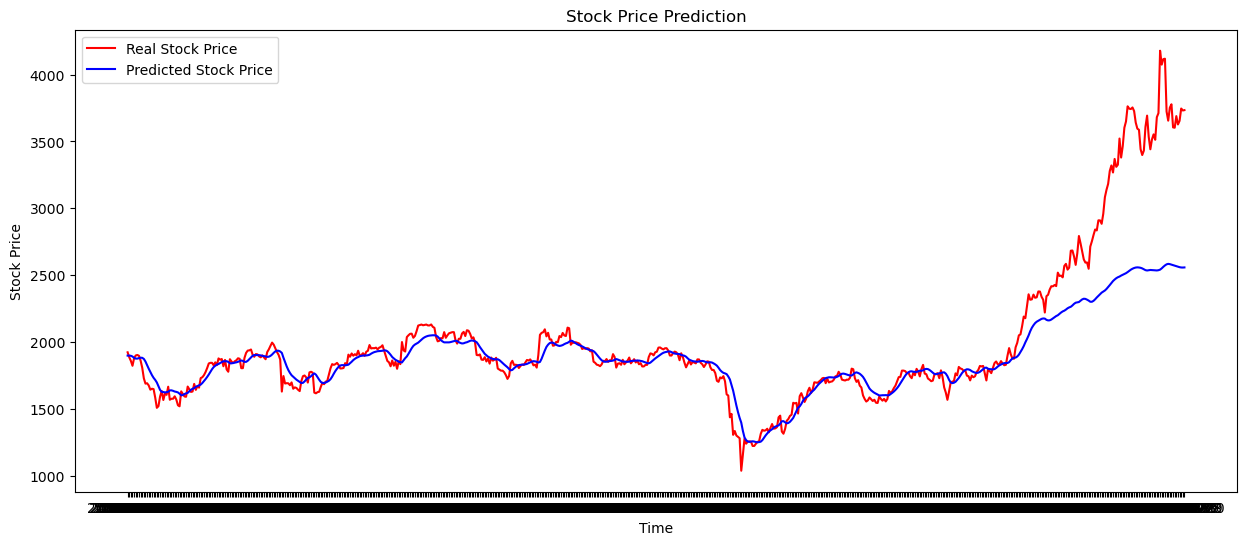

In [42]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df[len(df)-len(y_test):].index, y_test, color = 'red', label = 'Real Stock Price')
axes.plot(df[len(df)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Automate

In [43]:
from sklearn.metrics import mean_absolute_error

In [48]:
files = os.listdir('../data-corrected')
files.sort()
dpath = '../data-corrected/'
log = dict()
mpath = '/home/sharchit/Desktop/ml/finance/lstm/'
for file in files:
    try:
        df = pd.read_csv(dpath + files[0]).set_index('Date')
        df = df[['Close']]
        scaler = MinMaxScaler(feature_range=(-1, 1))
        df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
        look_back = 60 # choose sequence length
        x_train, y_train, x_test, y_test = load_data(df, look_back)

        x_train = torch.from_numpy(x_train).type(torch.Tensor)
        x_test = torch.from_numpy(x_test).type(torch.Tensor)
        y_train = torch.from_numpy(y_train).type(torch.Tensor)
        y_test = torch.from_numpy(y_test).type(torch.Tensor)

        input_dim = 1
        hidden_dim = 32
        num_layers = 2 
        output_dim = 1

        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
        loss_fn = torch.nn.MSELoss()

        optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

        num_epochs = 200
        hist = np.zeros(num_epochs)

        # Number of steps to unroll
        seq_dim =look_back-1  

        for t in range(num_epochs):
            # Initialise hidden state
            # Don't do this if you want your LSTM to be stateful
            #model.hidden = model.init_hidden()

            # Forward pass
            y_train_pred = model(x_train)

            loss = loss_fn(y_train_pred, y_train)
            print(f"{file}: Epoch ", t, "MSE: ", loss.item(), end = '\r')
            hist[t] = loss.item()

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss.backward()

            # Update parameters
            optimiser.step()

        y_test_pred = model(x_test)

        # invert predictions
        y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
        y_train = scaler.inverse_transform(y_train.detach().numpy())
        y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
        y_test = scaler.inverse_transform(y_test.detach().numpy())

        abse = mean_absolute_error(y_test, y_test_pred)
        log[file] = abse
        torch.save(model.state_dict(), mpath + file + '.pth')

    except:
        log[file] = 'ERROR'

In [50]:
log

{'ADANIPORTS.csv': 114.95201,
 'ASIANPAINT.csv': 134.85396,
 'AXISBANK.csv': 106.86127,
 'BAJAJ-AUTO.csv': 122.16871,
 'BAJAJFINSV.csv': 124.52014,
 'BAJFINANCE.csv': 107.97937,
 'BHARTIARTL.csv': 108.919106,
 'BPCL.csv': 111.86949,
 'BRITANNIA.csv': 127.038765,
 'CIPLA.csv': 126.8113,
 'COALINDIA.csv': 125.66876,
 'DRREDDY.csv': 116.70411,
 'EICHERMOT.csv': 118.00666,
 'GAIL.csv': 129.90282,
 'GRASIM.csv': 107.479675,
 'HCLTECH.csv': 91.317764,
 'HDFC.csv': 125.27837,
 'HDFCBANK.csv': 105.49968,
 'HEROMOTOCO.csv': 111.01835,
 'HINDALCO.csv': 108.31826,
 'HINDUNILVR.csv': 103.88594,
 'ICICIBANK.csv': 106.03784,
 'INDUSINDBK.csv': 90.03374,
 'INFRATEL.csv': 85.11056,
 'INFY.csv': 110.38613,
 'IOC.csv': 110.97511,
 'ITC.csv': 110.36145,
 'JSWSTEEL.csv': 120.90849,
 'KOTAKBANK.csv': 82.05811,
 'LT.csv': 122.43277,
 'MARUTI.csv': 122.18536,
 'MM.csv': 100.28324,
 'NESTLEIND.csv': 125.762344,
 'NTPC.csv': 110.66028,
 'ONGC.csv': 141.59813,
 'POWERGRID.csv': 131.06142,
 'RELIANCE.csv': 92.87

In [52]:
import json
for key, val in log.items():
    log[key] = str(val)
with open(mpath + 'log.json', 'w') as json_file:
    json.dump(log, json_file)